In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import date
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

# Tujuan :
## Untuk memprediksi apakah sebuah pesawat terbang, akan terkena delay, atau tidak.

# Datasets :
## https://www.kaggle.com/usdot/flight-delays 

### Delay atau keterlambatan jadwal penerbangan dari waktu yang telah di tentukan sering terjadi pada beberapa maskapai penerbangan. Keterlambatan ini bisa terjadi karena beberapa alasan, contohnya :
### 1. Cuaca yang kurang mendukung.
### 2. Kesiapan teknis dari pesawat yang akan membawa anda.
### 3. Padatnya lalu lintas penerbangan.

# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# Mari kita ambil contoh Indonesia, tahukah anda :
## Dalam Peraturan Menteri Nomor 77 tahun 2011 tentang tanggung jawab pengangkut Angkutan Udara. Penumpang mendapatkan hak – hak apabila terjadi delay pada penerbangan mereka:
### Keterlambatan lebih dari 4 jam akan di berikan ganti rugi sebesar Rp. 300.000,- per penumpang.
### Ganti rugi sebesar 50% dari ketentuan atau Rp. 150.000 per penumoang jika maskapai menawarkan tempat tujuan lain terdekat dari tujuan awal ( Rerouting ) dan maskapai wajib menyediakan tiket penerbangan lanjutan atau menyediakan transportasi lain sampai tempat tujuan apabila tidak ada moda transportasi selain angkutan udara.
### Dalam hal dialihkan ke penerbangan berikutnya atau penerbangan maskapai lain, penumpang di bebaskan dari biaya tambahan, termasuk jika harus naik kelas.

# -------------------------------------------------------------------------------------------------------------------------------------------------------------

## Maskapai mengalami kerugian secara materiil maupun immateriil. Contohnya: 
### Kompensasi dana bagi penumpang.
### Citra maskapai kepada publik.
### Biaya sewa parkir di bandara, yang semakin besar apabila mengalami delay.

# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# Deskripsi Data

### YEAR, MONTH, DAY, DAY_OF_WEEK : dates of the flight.
### AIRLINE : An identification number assigned by US DOT to identify a unique airline.
### ORIGIN_AIRPORT and DESTINATION_AIRPORT : code attributed by IATA to identify the airports.
### SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing.
### DEPARTURE_TIME and ARRIVAL_TIME : real times at which take-off and landing took place.
### DEPARTURE_DELAY and ARRIVAL_DELAY : difference (in minutes) between planned and real times.
### DISTANCE: distance (in miles).
### TAXI_IN : The time duration elapsed between wheels-on and gate arrival at the destination airport.
### TAXI_OUT: The time duration elapsed between departure from the origin airport gate and wheels off.
### WHEELS_ON : The time point that the aircraft's wheels touch on the ground.
### WHEELS_OFF : The time point that the aircraft's wheels leave the ground.
### AIR_TIME : The time duration between wheels_off and wheels_on time.
### ELAPSED_TIME : AIR_TIME + TAXI_IN + TAXI_OUT.
### SCHEDULED_TIME : Planned time amount needed for the flight trip.

In [2]:
df = pd.read_csv('flights.csv', low_memory=False)
df.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,20.0,-5.0,18.0,38.0,217.0,230.0,206.0,1589,604.0,6.0,602,610.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,19.0,-6.0,11.0,30.0,181.0,170.0,154.0,1299,504.0,5.0,526,509.0,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,44.0,14.0,13.0,57.0,273.0,249.0,228.0,2125,745.0,8.0,803,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,19.0,-11.0,17.0,36.0,195.0,193.0,173.0,1464,529.0,3.0,545,532.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,33.0,3.0,12.0,45.0,221.0,203.0,186.0,1747,651.0,5.0,711,656.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(df.shape)

(5819079, 31)


# Ada hampir 6 juta data, yang akan membuat proses pengolahan, ploting, dan juga model memakan waktu cukup lama. Untuk itu saya hanya akan mengambil sebagian data saja, sebesar 5% secara random.

In [4]:
df1 = df.sample(frac=0.05)
df1.shape

(290954, 31)

In [5]:
df1 = df1.reset_index(drop=True)

In [6]:
df1.shape

(290954, 31)

In [7]:
df1.to_csv('sample_Flights_Delay.csv')

In [8]:
def table_data(df):
    data=[]
    n=2
    for item in df.columns:
        if df[item].nunique()==1:
            n=1
        else:
            n=2
        data.append([
                    item,
                    df.dtypes.loc[item],
                    df[item].isna().sum(),
                    df[item].isna().sum()/len(df[item])*100,
                    df[item].nunique(),
                    list(df[df[item].notnull()].drop_duplicates(subset=item)[item].sample(n=n))
                    ])

    df_info = pd.DataFrame(data=data, columns=['dataFeatures', 'dataType','null','nullPct','unique','sample'])
    return df_info

# Mari kita lihat seperti apa data yang kita miliki :

In [9]:
df_info = table_data(df1)
df_info

,dataFeatures,dataType,null,nullPct,unique,sample
0,YEAR,int64,0,0.000000,1,[2015]
1,MONTH,int64,0,0.000000,12,"[5, 10]"
2,DAY,int64,0,0.000000,31,"[9, 19]"
3,DAY_OF_WEEK,int64,0,0.000000,7,"[4, 1]"
4,AIRLINE,object,0,0.000000,14,"[AA, F9]"
5,FLIGHT_NUMBER,int64,0,0.000000,6577,"[3631, 1981]"
6,TAIL_NUMBER,object,676,0.232339,4727,"[N969SW, N118US]"
7,ORIGIN_AIRPORT,object,0,0.000000,621,"[16218, RHI]"
8,DESTINATION_AIRPORT,object,0,0.000000,623,"[RIC, BUR]"
9,SCHEDULED_DEPARTURE,int64,0,0.000000,1261,"[1719, 1041]"


# Data Cleaning

### 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', kolom ataupun feature feature ini akan saya drop dikarnakan memiliki presentase "Null" yang begitu besar.

### 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'FLIGHT_NUMBER', 'TAIL_NUMBER', dan ada beberapa feature yang kurang begitu berguna untuk memprediksi apakah suatu pesawat akan delay atau tidak

In [10]:
variables_to_remove = [ 'AIR_SYSTEM_DELAY','SECURITY_DELAY', 'AIRLINE_DELAY'
                       ,'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'DIVERTED',
                       'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER']
df = df1.drop(variables_to_remove, axis = 1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290954 entries, 0 to 290953
Data columns (total 21 columns):
YEAR                   290954 non-null int64
MONTH                  290954 non-null int64
DAY                    290954 non-null int64
DAY_OF_WEEK            290954 non-null int64
AIRLINE                290954 non-null object
ORIGIN_AIRPORT         290954 non-null object
DESTINATION_AIRPORT    290954 non-null object
SCHEDULED_DEPARTURE    290954 non-null int64
DEPARTURE_TIME         286735 non-null float64
DEPARTURE_DELAY        286735 non-null float64
TAXI_OUT               286614 non-null float64
WHEELS_OFF             286614 non-null float64
SCHEDULED_TIME         290954 non-null float64
ELAPSED_TIME           285823 non-null float64
AIR_TIME               285823 non-null float64
DISTANCE               290954 non-null int64
WHEELS_ON              286438 non-null float64
TAXI_IN                286438 non-null float64
SCHEDULED_ARRIVAL      290954 non-null int64
ARRIVAL_TIME 

In [12]:
df.dropna(inplace=True)

In [13]:
df_info = table_data(df)
df_info

,dataFeatures,dataType,null,nullPct,unique,sample
0,YEAR,int64,0,0.0,1,[2015]
1,MONTH,int64,0,0.0,12,"[6, 4]"
2,DAY,int64,0,0.0,31,"[19, 6]"
3,DAY_OF_WEEK,int64,0,0.0,7,"[2, 6]"
4,AIRLINE,object,0,0.0,14,"[EV, NK]"
5,ORIGIN_AIRPORT,object,0,0.0,621,"[RDU, 12389]"
6,DESTINATION_AIRPORT,object,0,0.0,623,"[GSO, 11252]"
7,SCHEDULED_DEPARTURE,int64,0,0.0,1261,"[2034, 1204]"
8,DEPARTURE_TIME,float64,0,0.0,1381,"[211.0, 152.0]"
9,DEPARTURE_DELAY,float64,0,0.0,581,"[407.0, 389.0]"


In [14]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015,10,27,2,AS,14747,14679,840,837.0,-3.0,12.0,849.0,162.0,148.0,134.0,1050,1103.0,2.0,1122,1105.0,-17.0
1,2015,6,29,1,DL,SFO,MSP,620,746.0,86.0,11.0,757.0,218.0,210.0,193.0,1589,1310.0,6.0,1158,1316.0,78.0
2,2015,4,27,1,DL,AGS,ATL,710,711.0,1.0,9.0,720.0,53.0,48.0,30.0,143,750.0,9.0,803,759.0,-4.0
3,2015,1,14,3,OO,ONT,DEN,1315,1320.0,5.0,12.0,1332.0,133.0,134.0,115.0,819,1627.0,7.0,1628,1634.0,6.0
4,2015,6,8,1,US,CLT,BNA,1955,2051.0,56.0,18.0,2109.0,78.0,82.0,58.0,328,2107.0,6.0,2013,2113.0,60.0


# Untuk membuat data lebih rapi dan bersih, dan mempermudah untuk diproses nantinya, feature "YEAR", 'MONTH, 'DAY', akan dijadikan format datetime

In [15]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [16]:
# Pemisahan
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
    
#_____________________________________________________________________
# Menggabungkan tanggal dan waktu

def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
    
#_______________________________________________________________________________
# Function yang menggabungkan 2 kolom dataframe  uhntuk nantinya menjadi format datetime

def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows(): #return series setiap rows   
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1) #digunakan untuk menghitung perbedaan hari
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [17]:
format_heure(2400)

datetime.time(0, 0)

In [18]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['SCHEDULED_DEPARTURE'] = pd.to_datetime(df['SCHEDULED_DEPARTURE'])

df['DEPARTURE_TIME'] = create_flight_time(df, 'DEPARTURE_TIME')
df['DEPARTURE_TIME'] = pd.to_datetime(df['DEPARTURE_TIME'])

df['SCHEDULED_ARRIVAL'] = create_flight_time(df, 'SCHEDULED_ARRIVAL')
df['SCHEDULED_ARRIVAL'] = pd.to_datetime(df['SCHEDULED_ARRIVAL'])

df['ARRIVAL_TIME'] = create_flight_time(df, 'ARRIVAL_TIME')
df['ARRIVAL_TIME'] = pd.to_datetime(df['ARRIVAL_TIME'])

In [19]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-10-27 08:40:00,2015-10-27 11:22:00,2015-10-27 08:37:00,2015-10-27 11:05:00,-3.0,-17.0
1,2015-06-29 06:20:00,2015-06-29 11:58:00,2015-06-29 07:46:00,2015-06-29 13:16:00,86.0,78.0
2,2015-04-27 07:10:00,2015-04-27 08:03:00,2015-04-27 07:11:00,2015-04-27 07:59:00,1.0,-4.0
3,2015-01-14 13:15:00,2015-01-14 16:28:00,2015-01-14 13:20:00,2015-01-14 16:34:00,5.0,6.0
4,2015-06-08 19:55:00,2015-06-08 20:13:00,2015-06-08 20:51:00,2015-06-08 21:13:00,56.0,60.0
5,2015-09-07 15:15:00,2015-09-07 17:25:00,2015-09-07 15:52:00,2015-09-07 17:41:00,37.0,16.0


## Sekarang feature SCHEDULED_DEPARTURE 	SCHEDULED_ARRIVAL 	DEPARTURE_TIME 	ARRIVAL_TIME, menjadi format datetime

In [20]:
remove_date=['YEAR','MONTH','DAY','DAY_OF_WEEK']
df= df.drop(remove_date, axis = 1)

In [21]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DATE
0,AS,14747,14679,2015-10-27 08:40:00,2015-10-27 08:37:00,-3.0,12.0,849.0,162.0,148.0,134.0,1050,1103.0,2.0,2015-10-27 11:22:00,2015-10-27 11:05:00,-17.0,2015-10-27
1,DL,SFO,MSP,2015-06-29 06:20:00,2015-06-29 07:46:00,86.0,11.0,757.0,218.0,210.0,193.0,1589,1310.0,6.0,2015-06-29 11:58:00,2015-06-29 13:16:00,78.0,2015-06-29
2,DL,AGS,ATL,2015-04-27 07:10:00,2015-04-27 07:11:00,1.0,9.0,720.0,53.0,48.0,30.0,143,750.0,9.0,2015-04-27 08:03:00,2015-04-27 07:59:00,-4.0,2015-04-27
3,OO,ONT,DEN,2015-01-14 13:15:00,2015-01-14 13:20:00,5.0,12.0,1332.0,133.0,134.0,115.0,819,1627.0,7.0,2015-01-14 16:28:00,2015-01-14 16:34:00,6.0,2015-01-14
4,US,CLT,BNA,2015-06-08 19:55:00,2015-06-08 20:51:00,56.0,18.0,2109.0,78.0,82.0,58.0,328,2107.0,6.0,2015-06-08 20:13:00,2015-06-08 21:13:00,60.0,2015-06-08


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285823 entries, 0 to 290953
Data columns (total 18 columns):
AIRLINE                285823 non-null object
ORIGIN_AIRPORT         285823 non-null object
DESTINATION_AIRPORT    285823 non-null object
SCHEDULED_DEPARTURE    280765 non-null datetime64[ns]
DEPARTURE_TIME         280765 non-null datetime64[ns]
DEPARTURE_DELAY        285823 non-null float64
TAXI_OUT               285823 non-null float64
WHEELS_OFF             285823 non-null float64
SCHEDULED_TIME         285823 non-null float64
ELAPSED_TIME           285823 non-null float64
AIR_TIME               285823 non-null float64
DISTANCE               285823 non-null int64
WHEELS_ON              285823 non-null float64
TAXI_IN                285823 non-null float64
SCHEDULED_ARRIVAL      280765 non-null datetime64[ns]
ARRIVAL_TIME           280765 non-null datetime64[ns]
ARRIVAL_DELAY          285823 non-null float64
DATE                   285823 non-null datetime64[ns]
dtypes: datet

In [23]:
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT','DISTANCE',
    'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
    'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY','TAXI_OUT',
    'WHEELS_OFF','AIR_TIME','WHEELS_ON','TAXI_IN', 'ELAPSED_TIME',
    'SCHEDULED_TIME']]

In [24]:
df.dropna(inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280765 entries, 0 to 285822
Data columns (total 17 columns):
AIRLINE                280765 non-null object
ORIGIN_AIRPORT         280765 non-null object
DESTINATION_AIRPORT    280765 non-null object
DISTANCE               280765 non-null int64
SCHEDULED_DEPARTURE    280765 non-null datetime64[ns]
DEPARTURE_TIME         280765 non-null datetime64[ns]
DEPARTURE_DELAY        280765 non-null float64
SCHEDULED_ARRIVAL      280765 non-null datetime64[ns]
ARRIVAL_TIME           280765 non-null datetime64[ns]
ARRIVAL_DELAY          280765 non-null float64
TAXI_OUT               280765 non-null float64
WHEELS_OFF             280765 non-null float64
AIR_TIME               280765 non-null float64
WHEELS_ON              280765 non-null float64
TAXI_IN                280765 non-null float64
ELAPSED_TIME           280765 non-null float64
SCHEDULED_TIME         280765 non-null float64
dtypes: datetime64[ns](4), float64(9), int64(1), object(3)
memory u

In [26]:
df['SCHEDULED_ARRIVAL'][0]

Timestamp('2015-10-27 11:22:00')

In [27]:
df.describe()

,DISTANCE,DEPARTURE_DELAY,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME
count,280765.000000,280765.000000,280765.000000,280765.000000,280765.000000,280765.000000,280765.000000,280765.000000,280765.000000,280765.000000
mean,824.121518,9.293740,4.375948,16.059067,1357.204972,113.426360,1470.986790,7.411526,136.896953,141.814745
std,609.238234,36.987572,39.271818,8.871951,497.611436,72.223905,521.767599,5.546159,74.174819,75.336839
min,31.000000,-39.000000,-81.000000,1.000000,1.000000,7.000000,1.000000,1.000000,17.000000,18.000000
25%,373.000000,-5.000000,-13.000000,11.000000,935.000000,60.000000,1054.000000,4.000000,82.000000,85.000000
50%,650.000000,-2.000000,-5.000000,14.000000,1343.000000,94.000000,1508.000000,6.000000,118.000000,123.000000
75%,1065.000000,7.000000,8.000000,19.000000,1754.000000,144.000000,1911.000000,9.000000,168.000000,173.000000
max,4983.000000,1670.000000,1665.000000,180.000000,2400.000000,668.000000,2400.000000,174.000000,724.000000,680.000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280765 entries, 0 to 285822
Data columns (total 17 columns):
AIRLINE                280765 non-null object
ORIGIN_AIRPORT         280765 non-null object
DESTINATION_AIRPORT    280765 non-null object
DISTANCE               280765 non-null int64
SCHEDULED_DEPARTURE    280765 non-null datetime64[ns]
DEPARTURE_TIME         280765 non-null datetime64[ns]
DEPARTURE_DELAY        280765 non-null float64
SCHEDULED_ARRIVAL      280765 non-null datetime64[ns]
ARRIVAL_TIME           280765 non-null datetime64[ns]
ARRIVAL_DELAY          280765 non-null float64
TAXI_OUT               280765 non-null float64
WHEELS_OFF             280765 non-null float64
AIR_TIME               280765 non-null float64
WHEELS_ON              280765 non-null float64
TAXI_IN                280765 non-null float64
ELAPSED_TIME           280765 non-null float64
SCHEDULED_TIME         280765 non-null float64
dtypes: datetime64[ns](4), float64(9), int64(1), object(3)
memory u

In [29]:
df['TOTAL_DELAY']=(df['ARRIVAL_TIME']-df['SCHEDULED_ARRIVAL'])#.astype('timedelta64[m]')

In [30]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY
0,AS,14747,14679,1050,2015-10-27 08:40:00,2015-10-27 08:37:00,-3.0,2015-10-27 11:22:00,2015-10-27 11:05:00,-17.0,12.0,849.0,134.0,1103.0,2.0,148.0,162.0,-1 days +23:43:00
1,DL,SFO,MSP,1589,2015-06-29 06:20:00,2015-06-29 07:46:00,86.0,2015-06-29 11:58:00,2015-06-29 13:16:00,78.0,11.0,757.0,193.0,1310.0,6.0,210.0,218.0,01:18:00
2,DL,AGS,ATL,143,2015-04-27 07:10:00,2015-04-27 07:11:00,1.0,2015-04-27 08:03:00,2015-04-27 07:59:00,-4.0,9.0,720.0,30.0,750.0,9.0,48.0,53.0,-1 days +23:56:00
3,OO,ONT,DEN,819,2015-01-14 13:15:00,2015-01-14 13:20:00,5.0,2015-01-14 16:28:00,2015-01-14 16:34:00,6.0,12.0,1332.0,115.0,1627.0,7.0,134.0,133.0,00:06:00
4,US,CLT,BNA,328,2015-06-08 19:55:00,2015-06-08 20:51:00,56.0,2015-06-08 20:13:00,2015-06-08 21:13:00,60.0,18.0,2109.0,58.0,2107.0,6.0,82.0,78.0,01:00:00


## Dari 'TOTAL_DELAY' dimana 'TOTAL_DELAY' = ('ARRIVAL_TIME' dikurangi 'SCHEDULED_ARRIVAL'), dapat dibuat format 'TOTAL_DELAY' berdasarkan menit, untuk mempermudah analisa data 

In [31]:
def timedelta_format(x):
        sec = x.total_seconds()
        min_ = sec/60
        return min_

In [32]:
df['TOTAL_DELAY_MIN'] = df['TOTAL_DELAY'].apply(timedelta_format)

In [33]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN
0,AS,14747,14679,1050,2015-10-27 08:40:00,2015-10-27 08:37:00,-3.0,2015-10-27 11:22:00,2015-10-27 11:05:00,-17.0,12.0,849.0,134.0,1103.0,2.0,148.0,162.0,-1 days +23:43:00,-17.0
1,DL,SFO,MSP,1589,2015-06-29 06:20:00,2015-06-29 07:46:00,86.0,2015-06-29 11:58:00,2015-06-29 13:16:00,78.0,11.0,757.0,193.0,1310.0,6.0,210.0,218.0,01:18:00,78.0
2,DL,AGS,ATL,143,2015-04-27 07:10:00,2015-04-27 07:11:00,1.0,2015-04-27 08:03:00,2015-04-27 07:59:00,-4.0,9.0,720.0,30.0,750.0,9.0,48.0,53.0,-1 days +23:56:00,-4.0
3,OO,ONT,DEN,819,2015-01-14 13:15:00,2015-01-14 13:20:00,5.0,2015-01-14 16:28:00,2015-01-14 16:34:00,6.0,12.0,1332.0,115.0,1627.0,7.0,134.0,133.0,00:06:00,6.0
4,US,CLT,BNA,328,2015-06-08 19:55:00,2015-06-08 20:51:00,56.0,2015-06-08 20:13:00,2015-06-08 21:13:00,60.0,18.0,2109.0,58.0,2107.0,6.0,82.0,78.0,01:00:00,60.0


# Dengan mengetahui "TOTAL_DELAY_MIN", dapat dibuat feature "DELAY" dimana 1 adalah "TRUE" bahwa pesawat terkena delay, dan 0 adalah "FALSE".

In [34]:
df['DELAY']=df['TOTAL_DELAY_MIN'].apply(lambda x:1 if x>0 else 0)

In [35]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,AS,14747,14679,1050,2015-10-27 08:40:00,2015-10-27 08:37:00,-3.0,2015-10-27 11:22:00,2015-10-27 11:05:00,-17.0,12.0,849.0,134.0,1103.0,2.0,148.0,162.0,-1 days +23:43:00,-17.0,0
1,DL,SFO,MSP,1589,2015-06-29 06:20:00,2015-06-29 07:46:00,86.0,2015-06-29 11:58:00,2015-06-29 13:16:00,78.0,11.0,757.0,193.0,1310.0,6.0,210.0,218.0,01:18:00,78.0,1
2,DL,AGS,ATL,143,2015-04-27 07:10:00,2015-04-27 07:11:00,1.0,2015-04-27 08:03:00,2015-04-27 07:59:00,-4.0,9.0,720.0,30.0,750.0,9.0,48.0,53.0,-1 days +23:56:00,-4.0,0
3,OO,ONT,DEN,819,2015-01-14 13:15:00,2015-01-14 13:20:00,5.0,2015-01-14 16:28:00,2015-01-14 16:34:00,6.0,12.0,1332.0,115.0,1627.0,7.0,134.0,133.0,00:06:00,6.0,1
4,US,CLT,BNA,328,2015-06-08 19:55:00,2015-06-08 20:51:00,56.0,2015-06-08 20:13:00,2015-06-08 21:13:00,60.0,18.0,2109.0,58.0,2107.0,6.0,82.0,78.0,01:00:00,60.0,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280765 entries, 0 to 285822
Data columns (total 20 columns):
AIRLINE                280765 non-null object
ORIGIN_AIRPORT         280765 non-null object
DESTINATION_AIRPORT    280765 non-null object
DISTANCE               280765 non-null int64
SCHEDULED_DEPARTURE    280765 non-null datetime64[ns]
DEPARTURE_TIME         280765 non-null datetime64[ns]
DEPARTURE_DELAY        280765 non-null float64
SCHEDULED_ARRIVAL      280765 non-null datetime64[ns]
ARRIVAL_TIME           280765 non-null datetime64[ns]
ARRIVAL_DELAY          280765 non-null float64
TAXI_OUT               280765 non-null float64
WHEELS_OFF             280765 non-null float64
AIR_TIME               280765 non-null float64
WHEELS_ON              280765 non-null float64
TAXI_IN                280765 non-null float64
ELAPSED_TIME           280765 non-null float64
SCHEDULED_TIME         280765 non-null float64
TOTAL_DELAY            280765 non-null timedelta64[ns]
TOTAL_DELAY_

In [37]:
df_info = table_data(df)
df_info

,dataFeatures,dataType,null,nullPct,unique,sample
0,AIRLINE,object,0,0.0,14,"[VX, OO]"
1,ORIGIN_AIRPORT,object,0,0.0,621,"[10333, 10135]"
2,DESTINATION_AIRPORT,object,0,0.0,623,"[11292, DAY]"
3,DISTANCE,int64,0,0.0,1319,"[3329, 1842]"
4,SCHEDULED_DEPARTURE,datetime64[ns],0,0.0,134925,"[2015-04-06 18:38:00, 2015-02-03 20:33:00]"
5,DEPARTURE_TIME,datetime64[ns],0,0.0,197879,"[2015-09-10 18:24:00, 2015-09-23 08:05:00]"
6,DEPARTURE_DELAY,float64,0,0.0,580,"[136.0, 390.0]"
7,SCHEDULED_ARRIVAL,datetime64[ns],0,0.0,182586,"[2015-04-10 19:52:00, 2015-06-22 11:50:00]"
8,ARRIVAL_TIME,datetime64[ns],0,0.0,201790,"[2015-11-20 20:24:00, 2015-05-22 10:15:00]"
9,ARRIVAL_DELAY,float64,0,0.0,623,"[179.0, 541.0]"


In [38]:
df['DELAY'].value_counts()

0    180905
1     99860
Name: DELAY, dtype: int64

# Menambahkan data airline atau maskapai pada data df

In [39]:
airlines = pd.read_csv('airlines.csv')
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [40]:
abbr_airlines = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()
abbr_airlines

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

In [41]:
df['ABBR_AIRLINE']=df['AIRLINE'].apply(lambda x :abbr_airlines[x])

In [42]:
df = df[['AIRLINE','ABBR_AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DISTANCE', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
    'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY','TAXI_OUT',
    'WHEELS_OFF','AIR_TIME','WHEELS_ON','TAXI_IN', 'ELAPSED_TIME',
    'SCHEDULED_TIME','TOTAL_DELAY','TOTAL_DELAY_MIN','DELAY']]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280765 entries, 0 to 285822
Data columns (total 21 columns):
AIRLINE                280765 non-null object
ABBR_AIRLINE           280765 non-null object
ORIGIN_AIRPORT         280765 non-null object
DESTINATION_AIRPORT    280765 non-null object
DISTANCE               280765 non-null int64
SCHEDULED_DEPARTURE    280765 non-null datetime64[ns]
DEPARTURE_TIME         280765 non-null datetime64[ns]
DEPARTURE_DELAY        280765 non-null float64
SCHEDULED_ARRIVAL      280765 non-null datetime64[ns]
ARRIVAL_TIME           280765 non-null datetime64[ns]
ARRIVAL_DELAY          280765 non-null float64
TAXI_OUT               280765 non-null float64
WHEELS_OFF             280765 non-null float64
AIR_TIME               280765 non-null float64
WHEELS_ON              280765 non-null float64
TAXI_IN                280765 non-null float64
ELAPSED_TIME           280765 non-null float64
SCHEDULED_TIME         280765 non-null float64
TOTAL_DELAY          

# df.to_csv('sample_Flights_Delay.csv',index=False)

# df = pd.read_csv('sample_Flights_Delay.csv')

# Dataframe kita save untuk nantinya dimasukkan ke dalam database, dimana MYSQL sebagai database management yang dipakai

In [44]:
for item in df[['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']]:
    df[item] = df[item].astype('datetime64[ns]')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280765 entries, 0 to 285822
Data columns (total 21 columns):
AIRLINE                280765 non-null object
ABBR_AIRLINE           280765 non-null object
ORIGIN_AIRPORT         280765 non-null object
DESTINATION_AIRPORT    280765 non-null object
DISTANCE               280765 non-null int64
SCHEDULED_DEPARTURE    280765 non-null datetime64[ns]
DEPARTURE_TIME         280765 non-null datetime64[ns]
DEPARTURE_DELAY        280765 non-null float64
SCHEDULED_ARRIVAL      280765 non-null datetime64[ns]
ARRIVAL_TIME           280765 non-null datetime64[ns]
ARRIVAL_DELAY          280765 non-null float64
TAXI_OUT               280765 non-null float64
WHEELS_OFF             280765 non-null float64
AIR_TIME               280765 non-null float64
WHEELS_ON              280765 non-null float64
TAXI_IN                280765 non-null float64
ELAPSED_TIME           280765 non-null float64
SCHEDULED_TIME         280765 non-null float64
TOTAL_DELAY          

In [46]:
print(df['ORIGIN_AIRPORT'].value_counts())
print((df['ORIGIN_AIRPORT'].nunique()))

ATL      17191
ORD      13668
DFW      11461
LAX       9566
DEN       9476
PHX       7247
SFO       7104
IAH       7103
LAS       6488
MCO       5416
MSP       5409
SEA       5354
DTW       5138
BOS       5117
EWR       4924
CLT       4744
SLC       4662
LGA       4572
JFK       4468
BWI       4145
MDW       3804
DCA       3512
MIA       3496
SAN       3463
FLL       3458
PHL       3135
TPA       3110
DAL       2943
HOU       2494
PDX       2340
         ...  
14520        3
10146        3
10581        2
10779        2
12265        2
14254        2
15991        2
15841        2
14109        2
10170        2
AKN          2
12094        2
HYA          2
12016        2
13933        2
11076        2
14905        2
11525        2
12519        2
15041        2
10918        2
ITH          2
13459        1
13502        1
14025        1
14006        1
10154        1
10165        1
12511        1
14543        1
Name: ORIGIN_AIRPORT, Length: 621, dtype: int64
621


In [47]:
df[df['TOTAL_DELAY_MIN'] < -100].sort_values(by='TOTAL_DELAY_MIN',ascending=False)

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
17183,F9,Frontier Airlines Inc.,MCO,STL,882,2015-01-16 19:30:00,2015-01-16 16:39:00,-7.0,2015-01-16 06:54:00,2015-01-16 03:23:00,-10.0,12.0,2110.0,118.0,2208.0,7.0,137.0,140.0,-1 days +20:29:00,-211.0,0
232913,AA,American Airlines Inc.,DFW,IND,761,2015-09-03 13:25:00,2015-09-03 09:51:00,-6.0,2015-09-03 21:53:00,2015-09-03 18:15:00,-19.0,14.0,1545.0,103.0,1828.0,5.0,122.0,135.0,-1 days +20:22:00,-218.0,0
278491,MQ,American Eagle Airlines Inc.,11413,11298,674,2015-06-13 14:00:00,2015-06-13 10:10:00,-18.0,2015-06-13 15:56:00,2015-06-13 11:52:00,-28.0,14.0,811.0,93.0,1044.0,7.0,114.0,124.0,-1 days +19:56:00,-244.0,0
76008,VX,Virgin America,SEA,SFO,679,2015-08-13 13:53:00,2015-08-13 09:04:00,13.0,2015-08-13 15:44:00,2015-08-13 11:23:00,0.0,14.0,727.0,98.0,905.0,5.0,117.0,130.0,-1 days +19:39:00,-261.0,0
118005,B6,JetBlue Airways,FLL,LGA,1076,2015-03-01 14:20:00,2015-03-01 09:46:00,134.0,2015-03-01 16:30:00,2015-03-01 12:00:00,162.0,28.0,2124.0,155.0,2359.0,12.0,195.0,167.0,-1 days +19:30:00,-270.0,0
152030,EV,Atlantic Southeast Airlines,EWR,ORF,284,2015-02-21 18:11:00,2015-02-21 13:25:00,-3.0,2015-02-21 19:40:00,2015-02-21 14:52:00,-16.0,14.0,1742.0,52.0,1834.0,5.0,71.0,84.0,-1 days +19:12:00,-288.0,0
89724,US,US Airways Inc.,CLT,TPA,507,2015-08-23 16:19:00,2015-08-23 11:35:00,-3.0,2015-08-23 19:05:00,2015-08-23 14:08:00,-8.0,11.0,1633.0,79.0,1752.0,5.0,95.0,100.0,-1 days +19:03:00,-297.0,0
266593,AA,American Airlines Inc.,PHX,SFO,651,2015-04-28 15:10:00,2015-04-28 09:50:00,-2.0,2015-04-28 19:18:00,2015-04-28 14:06:00,-12.0,20.0,1038.0,96.0,1214.0,3.0,119.0,129.0,-1 days +18:48:00,-312.0,0
5615,EV,Atlantic Southeast Airlines,GRK,ATL,803,2015-03-08 13:25:00,2015-03-08 08:24:00,-4.0,2015-03-08 15:17:00,2015-03-08 09:57:00,1.0,13.0,624.0,109.0,913.0,11.0,133.0,128.0,-1 days +18:40:00,-320.0,0
162579,WN,Southwest Airlines Co.,13232,14100,668,2015-10-12 17:20:00,2015-10-12 12:02:00,-5.0,2015-10-12 18:16:00,2015-10-12 12:41:00,-24.0,10.0,1110.0,80.0,1330.0,6.0,96.0,115.0,-1 days +18:25:00,-335.0,0


In [48]:
df[df['TOTAL_DELAY_MIN'] >1000].sort_values(by='TOTAL_DELAY_MIN', ascending=True)

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
284829,B6,JetBlue Airways,BOS,RIC,474,2015-04-27 19:55:00,2015-04-27 19:49:00,-12.0,2015-04-27 00:30:00,2015-04-27 23:31:00,-24.0,14.0,1036.0,69.0,1145.0,5.0,88.0,100.0,23:01:00,1381.0,1
125723,WN,Southwest Airlines Co.,PDX,SMF,479,2015-04-24 20:29:00,2015-04-24 20:29:00,-1.0,2015-04-24 00:28:00,2015-04-24 23:37:00,-6.0,6.0,1600.0,69.0,1709.0,5.0,80.0,85.0,23:09:00,1389.0,1
196909,WN,Southwest Airlines Co.,BWI,BNA,587,2015-04-30 22:29:00,2015-04-30 22:24:00,-4.0,2015-04-30 00:19:00,2015-04-30 23:29:00,-26.0,15.0,711.0,80.0,731.0,8.0,103.0,125.0,23:10:00,1390.0,1
142507,US,US Airways Inc.,PHX,RNO,601,2015-08-10 16:12:00,2015-08-10 16:03:00,-5.0,2015-08-10 00:30:00,2015-08-10 23:41:00,-8.0,11.0,1651.0,87.0,1818.0,5.0,103.0,106.0,23:11:00,1391.0,1
41854,AA,American Airlines Inc.,DEN,ORD,888,2015-04-28 22:29:00,2015-04-28 22:07:00,-6.0,2015-04-28 00:19:00,2015-04-28 23:31:00,-9.0,19.0,603.0,105.0,848.0,22.0,146.0,149.0,23:12:00,1392.0,1
158606,OO,Skywest Airlines Inc.,SLC,ORD,1250,2015-08-09 16:15:00,2015-08-09 16:08:00,48.0,2015-08-09 00:47:00,2015-08-09 23:59:00,34.0,16.0,1631.0,144.0,1955.0,16.0,176.0,190.0,23:12:00,1392.0,1
235001,EV,Atlantic Southeast Airlines,BHM,DTW,625,2015-05-02 21:30:00,2015-05-02 21:23:00,117.0,2015-05-02 00:31:00,2015-05-02 23:44:00,113.0,13.0,1228.0,95.0,1503.0,5.0,113.0,117.0,23:13:00,1393.0,1
62678,B6,JetBlue Airways,MCO,AUS,994,2015-06-17 22:30:00,2015-06-17 22:24:00,21.0,2015-06-17 00:38:00,2015-06-17 23:52:00,6.0,18.0,1334.0,136.0,1450.0,5.0,159.0,174.0,23:14:00,1394.0,1
134410,WN,Southwest Airlines Co.,BWI,RSW,919,2015-04-13 21:29:00,2015-04-13 21:21:00,27.0,2015-04-13 00:29:00,2015-04-13 23:43:00,24.0,8.0,1620.0,139.0,1839.0,5.0,152.0,155.0,23:14:00,1394.0,1
249233,AA,American Airlines Inc.,DFW,TUL,237,2015-09-19 20:50:00,2015-09-19 20:48:00,-6.0,2015-09-19 00:28:00,2015-09-19 23:42:00,-4.0,36.0,1240.0,36.0,1316.0,4.0,76.0,74.0,23:14:00,1394.0,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280765 entries, 0 to 285822
Data columns (total 21 columns):
AIRLINE                280765 non-null object
ABBR_AIRLINE           280765 non-null object
ORIGIN_AIRPORT         280765 non-null object
DESTINATION_AIRPORT    280765 non-null object
DISTANCE               280765 non-null int64
SCHEDULED_DEPARTURE    280765 non-null datetime64[ns]
DEPARTURE_TIME         280765 non-null datetime64[ns]
DEPARTURE_DELAY        280765 non-null float64
SCHEDULED_ARRIVAL      280765 non-null datetime64[ns]
ARRIVAL_TIME           280765 non-null datetime64[ns]
ARRIVAL_DELAY          280765 non-null float64
TAXI_OUT               280765 non-null float64
WHEELS_OFF             280765 non-null float64
AIR_TIME               280765 non-null float64
WHEELS_ON              280765 non-null float64
TAXI_IN                280765 non-null float64
ELAPSED_TIME           280765 non-null float64
SCHEDULED_TIME         280765 non-null float64
TOTAL_DELAY          

In [50]:
con_=(df['TOTAL_DELAY_MIN'] <-100)|(df['TOTAL_DELAY_MIN'] >1000)
df = df.drop(df[con_].index)

In [51]:
# df[df['TOTAL_DELAY_MIN'] >1000]
# df[df['TOTAL_DELAY_MIN'] <-100]
len(df[df['TOTAL_DELAY_MIN'] <-100])

0

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276933 entries, 0 to 285822
Data columns (total 21 columns):
AIRLINE                276933 non-null object
ABBR_AIRLINE           276933 non-null object
ORIGIN_AIRPORT         276933 non-null object
DESTINATION_AIRPORT    276933 non-null object
DISTANCE               276933 non-null int64
SCHEDULED_DEPARTURE    276933 non-null datetime64[ns]
DEPARTURE_TIME         276933 non-null datetime64[ns]
DEPARTURE_DELAY        276933 non-null float64
SCHEDULED_ARRIVAL      276933 non-null datetime64[ns]
ARRIVAL_TIME           276933 non-null datetime64[ns]
ARRIVAL_DELAY          276933 non-null float64
TAXI_OUT               276933 non-null float64
WHEELS_OFF             276933 non-null float64
AIR_TIME               276933 non-null float64
WHEELS_ON              276933 non-null float64
TAXI_IN                276933 non-null float64
ELAPSED_TIME           276933 non-null float64
SCHEDULED_TIME         276933 non-null float64
TOTAL_DELAY          

# EDA 
## Tujuan : 
### Mengetahui performa maskapai maupun bandara.
### Analisa data melalui visualisasi.
### Mengetahui hal -hal yang berpengaruh untuk Delay.

## Melihat min, max, mean untuk setiap maskapainya berdasarkan feature TOTAL_DELAY

In [53]:
gb_airlines = df.groupby('AIRLINE')
des_total_delay = gb_airlines['TOTAL_DELAY_MIN'].describe().sort_values(by=['mean','75%'],ascending=False)
des_total_delay.index = [abbr_airlines[item] for item in abbr_airlines]
des_total_delay

,count,mean,std,min,25%,50%,75%,max
United Air Lines Inc.,3710.0,3.797574,37.332565,-51.0,-14.0,-5.0,7.0,614.0
American Airlines Inc.,5601.0,3.514730,35.523370,-74.0,-14.0,-5.0,8.0,515.0
US Airways Inc.,28133.0,3.236128,34.892112,-59.0,-13.0,-5.0,7.0,697.0
Frontier Airlines Inc.,27027.0,3.206645,35.346218,-62.0,-13.0,-5.0,7.0,816.0
JetBlue Airways,60084.0,3.167133,35.230398,-67.0,-13.0,-5.0,7.0,770.0
Skywest Airlines Inc.,42235.0,3.141186,34.394283,-65.0,-13.0,-5.0,7.0,755.0
Alaska Airlines Inc.,8324.0,3.113888,33.629263,-56.0,-13.0,-5.0,7.0,560.0
Spirit Air Lines,34406.0,3.109661,34.046527,-73.0,-13.0,-5.0,7.0,847.0
Southwest Airlines Co.,3029.0,3.055794,37.677136,-46.0,-13.0,-5.0,7.0,838.0
Delta Air Lines Inc.,13579.0,3.039988,34.862387,-67.0,-13.0,-5.0,7.0,648.0


## Kita dapat melihat performa setiap maskapai.

##  Dan dapat dilihat masih banyak outlier

## Data yang memiliki total delay lebih dari 60 menit akan didrop, untuk melihat data yang "tidak outlier" 

In [54]:
condition = (df['TOTAL_DELAY_MIN']<=60)&(df['DEPARTURE_DELAY']<=120)&(df['ARRIVAL_DELAY']<=120)
gb_airlines = df[condition].groupby('AIRLINE')

# Ada 2 Delay yang dapat dilihat yaitu Departure Delay dan Arrival Delay
## Departure Delay per maskapai 

In [55]:
des_dep_delay = gb_airlines['DEPARTURE_DELAY'].describe().sort_values(by=['mean','75%'],ascending=False)
des_dep_delay.index = [abbr_airlines[item] for item in abbr_airlines]
des_dep_delay

,count,mean,std,min,25%,50%,75%,max
United Air Lines Inc.,5052.0,9.206849,25.088222,-21.0,-6.0,-1.0,14.0,120.0
American Airlines Inc.,22597.0,8.781962,22.333789,-20.0,-4.0,0.0,11.0,120.0
US Airways Inc.,56067.0,7.580948,19.665255,-15.0,-3.0,0.0,10.0,120.0
Frontier Airlines Inc.,11614.0,6.349061,22.406553,-24.0,-6.0,-2.0,8.0,120.0
JetBlue Airways,3946.0,6.303092,23.799359,-32.0,-7.0,-3.0,9.0,120.0
Skywest Airlines Inc.,12607.0,5.038233,20.949698,-22.0,-6.0,-3.0,5.0,120.0
Alaska Airlines Inc.,2846.0,4.916725,18.394995,-18.0,-4.0,-1.0,5.0,117.0
Spirit Air Lines,32086.0,4.613757,19.701157,-26.0,-5.0,-2.0,4.0,120.0
Southwest Airlines Co.,25019.0,3.771534,20.780415,-33.0,-6.0,-3.0,3.0,120.0
Delta Air Lines Inc.,39465.0,3.702065,16.743067,-21.0,-4.0,-2.0,3.0,120.0


## Arrival Delay per maskapai

In [56]:
des_arr_delay = gb_airlines['ARRIVAL_DELAY'].describe().sort_values(by=['mean','75%'],ascending=False)
des_arr_delay.index = [abbr_airlines[item] for item in abbr_airlines]
des_arr_delay

,count,mean,std,min,25%,50%,75%,max
United Air Lines Inc.,5052.0,7.378662,27.587117,-55.0,-11.0,-1.0,16.0,120.0
American Airlines Inc.,3946.0,5.266092,27.068559,-47.0,-12.0,-2.0,14.0,118.0
US Airways Inc.,26133.0,1.595339,22.929717,-64.0,-12.0,-4.0,7.0,120.0
Frontier Airlines Inc.,25019.0,1.594788,23.771735,-63.0,-13.0,-5.0,7.0,120.0
JetBlue Airways,11614.0,1.444636,26.075168,-74.0,-15.0,-6.0,10.0,120.0
Skywest Airlines Inc.,56067.0,1.350456,22.445718,-58.0,-12.0,-4.0,7.0,120.0
Alaska Airlines Inc.,12607.0,1.109146,25.462490,-52.0,-15.0,-6.0,8.0,120.0
Spirit Air Lines,3500.0,0.796286,14.768982,-51.0,-7.0,-2.0,5.0,119.0
Southwest Airlines Co.,8695.0,0.713283,22.318512,-61.0,-12.0,-4.0,7.0,120.0
Delta Air Lines Inc.,2846.0,0.643710,22.758090,-62.0,-12.0,-4.0,8.0,119.0


## Total Delay per maskapai

In [57]:
des_total_delay = gb_airlines['TOTAL_DELAY_MIN'].describe().sort_values(by=['mean','75%'],ascending=False)
des_total_delay.index = [abbr_airlines[item] for item in abbr_airlines]
des_total_delay

,count,mean,std,min,25%,50%,75%,max
United Air Lines Inc.,3946.0,-2.562848,17.701302,-53.0,-14.0,-6.0,5.0,60.0
American Airlines Inc.,32086.0,-2.617434,17.223670,-73.0,-14.0,-6.0,5.0,60.0
US Airways Inc.,12607.0,-2.623542,17.397982,-67.0,-14.0,-6.0,5.0,60.0
Frontier Airlines Inc.,7830.0,-2.790038,16.562769,-56.0,-13.0,-6.0,4.0,60.0
JetBlue Airways,39465.0,-2.834942,17.124296,-65.0,-14.0,-6.0,5.0,60.0
Skywest Airlines Inc.,25019.0,-2.851593,17.201079,-62.0,-14.0,-6.0,4.0,60.0
Alaska Airlines Inc.,2846.0,-2.864020,17.222664,-46.0,-14.0,-6.0,5.0,60.0
Spirit Air Lines,26133.0,-2.904680,17.082555,-59.0,-14.0,-6.0,4.0,60.0
Southwest Airlines Co.,22597.0,-2.910475,17.049331,-65.0,-14.0,-6.0,4.0,60.0
Delta Air Lines Inc.,56067.0,-2.974994,17.050433,-67.0,-14.0,-6.0,4.0,60.0


# Visualisasi Data

### untuk melihat hubungan maskapai dan delay

### Kita dapat melihat jumlah penerbangan setiap maskapai pada sample ini

In [58]:
colors = ['firebrick', 'royalblue', 'grey', 'wheat', 'c', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

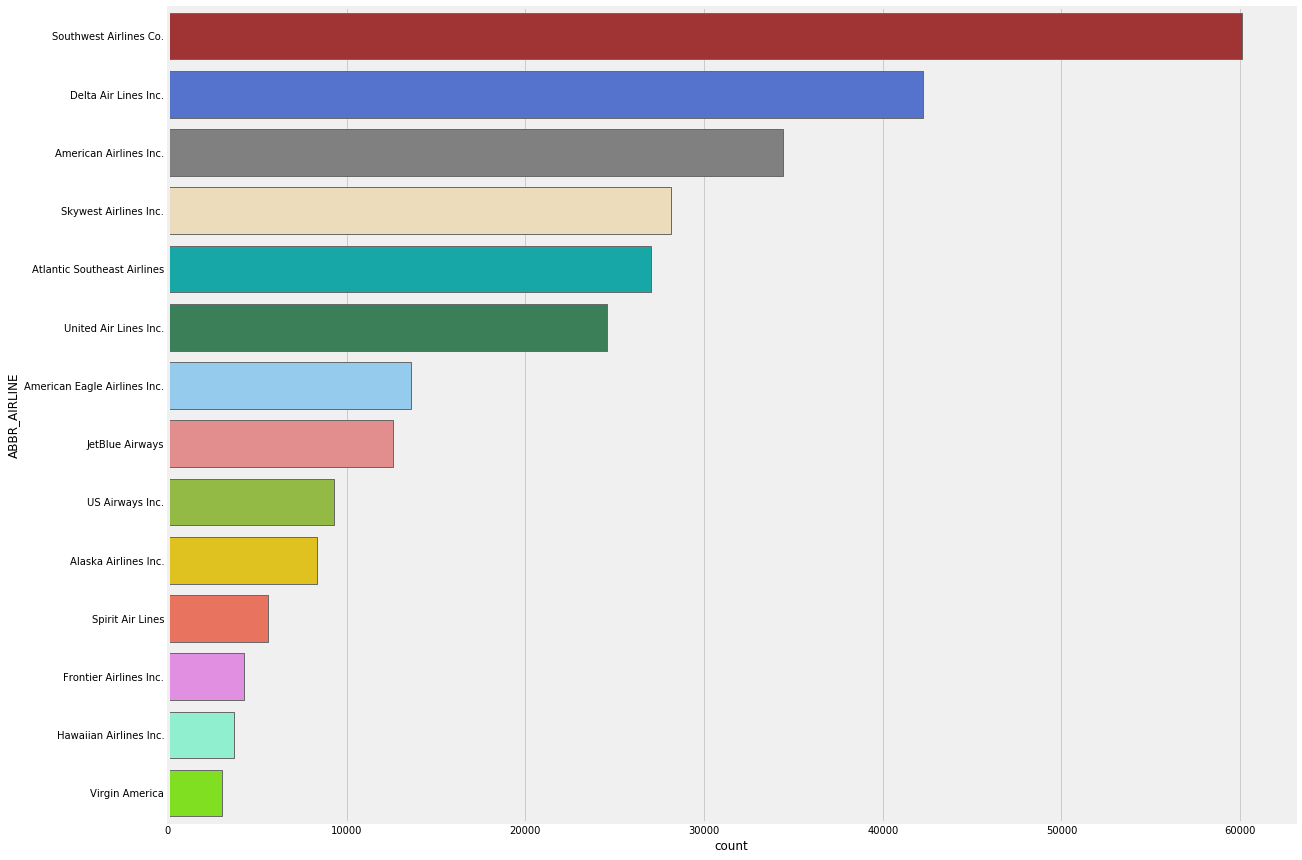

In [59]:
plt.figure(figsize=(18,15))
ax3 = sns.countplot(y='ABBR_AIRLINE', palette = colors,
                    data=df,order = df['ABBR_AIRLINE'].value_counts().index)

In [60]:
df['ABBR_AIRLINE'].value_counts()

Southwest Airlines Co.          60084
Delta Air Lines Inc.            42235
American Airlines Inc.          34406
Skywest Airlines Inc.           28133
Atlantic Southeast Airlines     27027
United Air Lines Inc.           24591
American Eagle Airlines Inc.    13579
JetBlue Airways                 12625
US Airways Inc.                  9305
Alaska Airlines Inc.             8324
Spirit Air Lines                 5601
Frontier Airlines Inc.           4284
Hawaiian Airlines Inc.           3710
Virgin America                   3029
Name: ABBR_AIRLINE, dtype: int64

# Mari kita lihat maskapai yang memiliki catatan "DELAYED" terbanyak

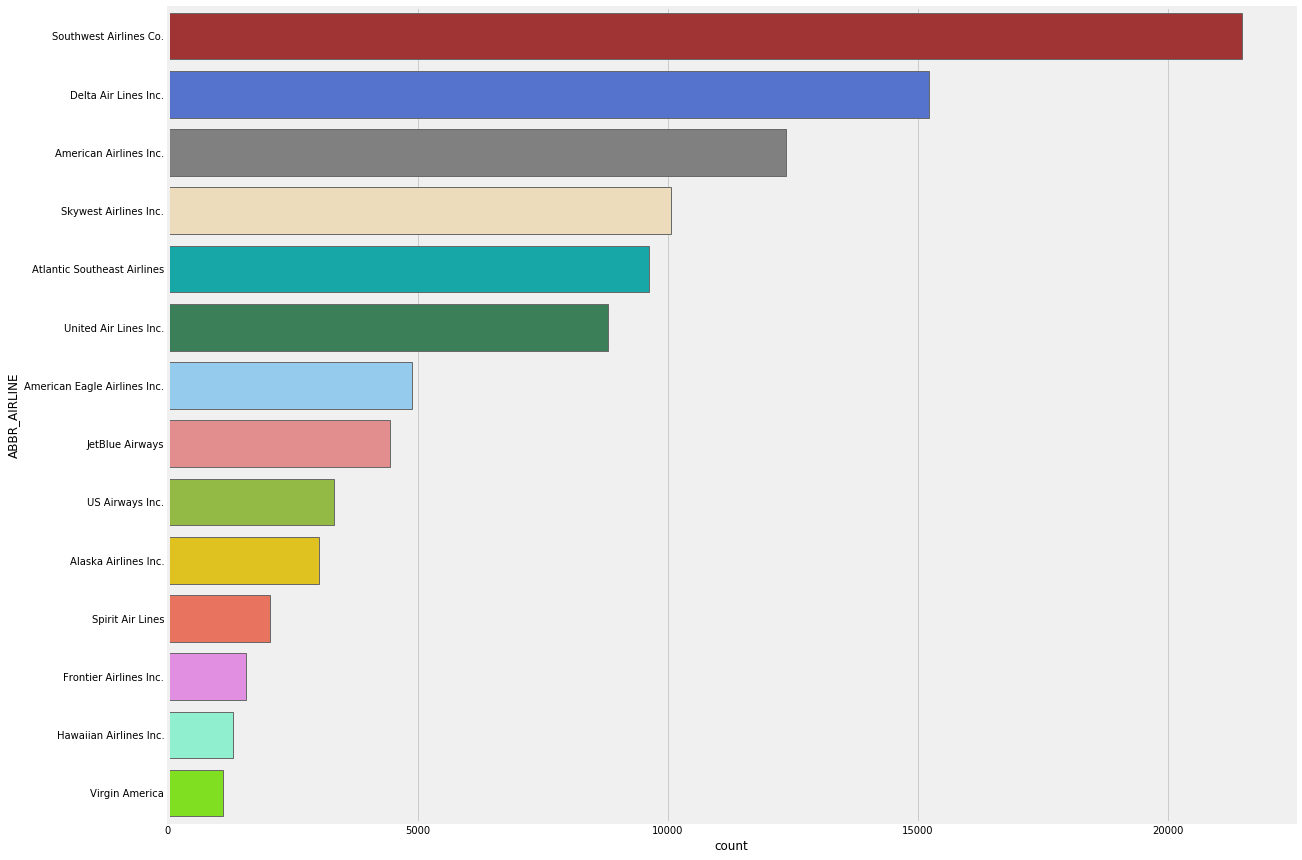

In [61]:
plt.figure(figsize=(18,15))
ax3 = sns.countplot(y='ABBR_AIRLINE', palette = colors,
                    data=df[df['DELAY']==1],
                    order = df[df['DELAY']==1]['ABBR_AIRLINE'].value_counts().index)

In [62]:
df[df['DELAY']==1]['ABBR_AIRLINE'].value_counts()

Southwest Airlines Co.          21478
Delta Air Lines Inc.            15222
American Airlines Inc.          12361
Skywest Airlines Inc.           10063
Atlantic Southeast Airlines      9633
United Air Lines Inc.            8801
American Eagle Airlines Inc.     4891
JetBlue Airways                  4453
US Airways Inc.                  3316
Alaska Airlines Inc.             3032
Spirit Air Lines                 2051
Frontier Airlines Inc.           1570
Hawaiian Airlines Inc.           1312
Virgin America                   1100
Name: ABBR_AIRLINE, dtype: int64

# Presentase kemungkinan delay setiap maskapainya

In [63]:
airlines_count = df['ABBR_AIRLINE'].value_counts().sort_index()
delay_1 = df[df['DELAY'] == 1]['ABBR_AIRLINE'].value_counts().sort_index()

delay_pct = delay_1/airlines_count
delay_pct = delay_pct.sort_values(ascending=False)
delay_pct

Frontier Airlines Inc.          0.366480
Spirit Air Lines                0.366185
Alaska Airlines Inc.            0.364248
Virgin America                  0.363156
Delta Air Lines Inc.            0.360412
American Eagle Airlines Inc.    0.360189
American Airlines Inc.          0.359269
United Air Lines Inc.           0.357895
Skywest Airlines Inc.           0.357694
Southwest Airlines Co.          0.357466
Atlantic Southeast Airlines     0.356421
US Airways Inc.                 0.356368
Hawaiian Airlines Inc.          0.353639
JetBlue Airways                 0.352713
Name: ABBR_AIRLINE, dtype: float64

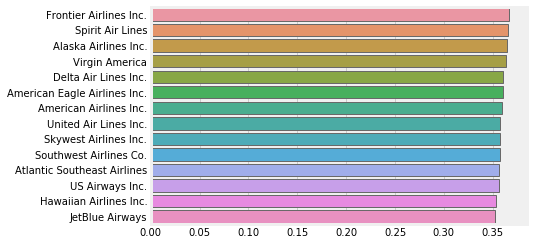

In [64]:
ax = sns.barplot(x=delay_pct.values,y=delay_pct.index)

## Dapat dilihat kemungkinan delay setiap maskapainya, dengan rata rata kemungkinan delay antara satu maskapai dengan maskapai lainnya tidak jauh berbeda. Walaupun nama perusahaan maskapai sendiri tidak terlalu bersangkut paut dengan delay, namun lebih bersangkut paut dengan "durasi" dari delay tersebut.

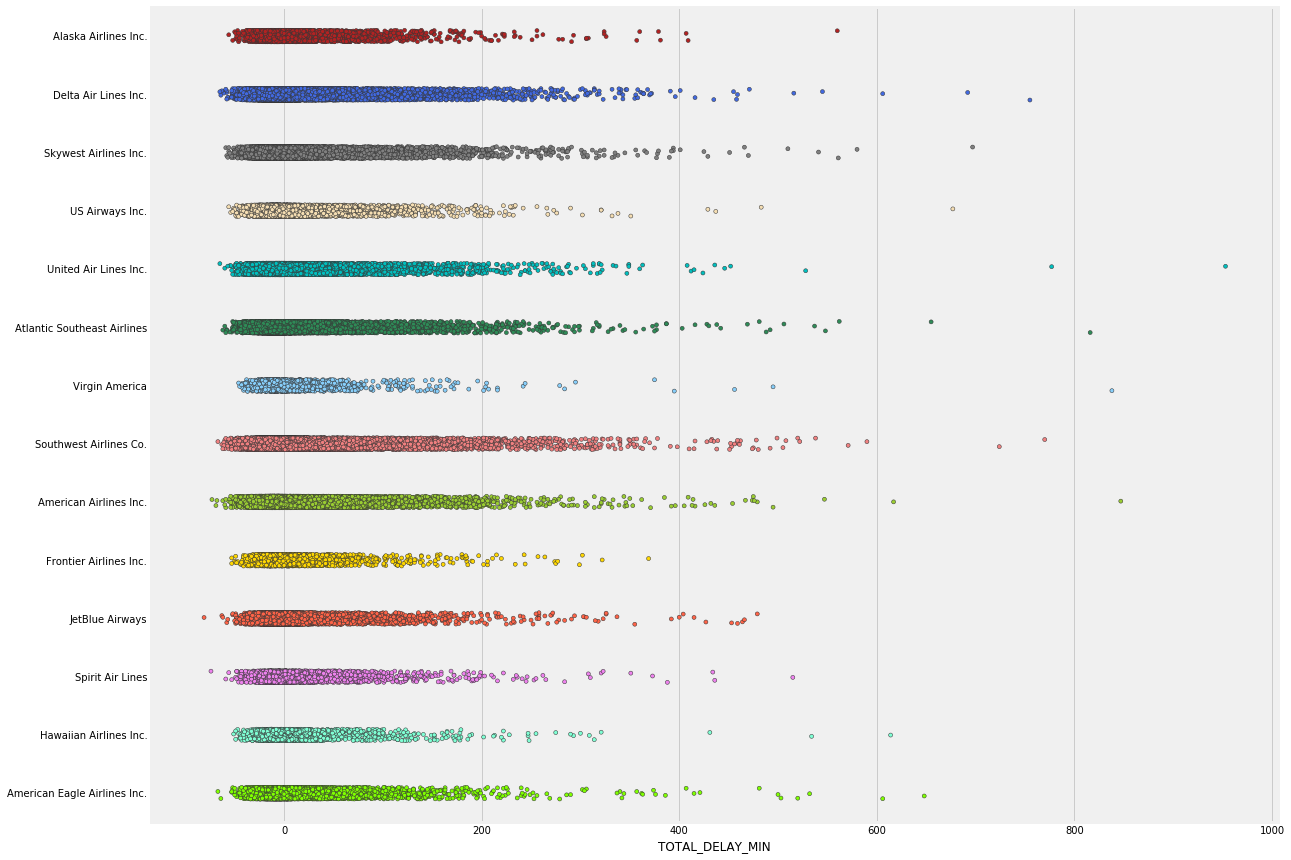

In [65]:
plt.figure(figsize=(18,15))
labels = [s for s in  des_total_delay.index]
ax3 = sns.stripplot(y='ABBR_AIRLINE', x='TOTAL_DELAY_MIN', size = 4, palette = colors,
                    data=df, linewidth = 0.5,  jitter=True)
ax3.yaxis.label.set_visible(False)

### Dari grafik tersebut kita dapat melihat maskapai delay paling lama (based on average).

## Sekarang mari cari tahu "Bulan berapa?" yang paling banyak terjadinya delay.

In [66]:
df['SD_MONTH']=df['SCHEDULED_DEPARTURE'].dt.month

In [67]:
df = df[['AIRLINE', 'ABBR_AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
         'DISTANCE','SD_MONTH','SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
         'DEPARTURE_DELAY','SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
         'ARRIVAL_DELAY', 'TAXI_OUT','WHEELS_OFF', 'AIR_TIME', 
         'WHEELS_ON', 'TAXI_IN', 'ELAPSED_TIME','SCHEDULED_TIME', 
         'TOTAL_DELAY', 'TOTAL_DELAY_MIN', 'DELAY']]

Text(0,0.5,'Total Delay(min)')

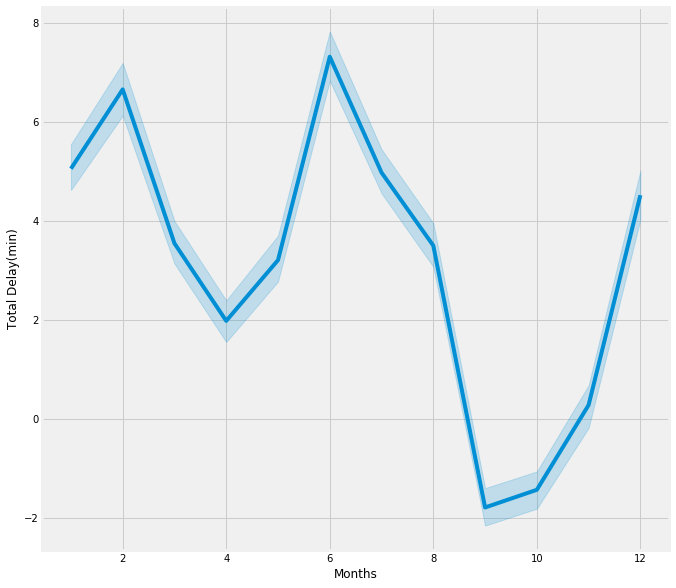

In [68]:
plt.figure(figsize=(10,10))
ax = sns.lineplot(x='SD_MONTH', y="TOTAL_DELAY_MIN",
                  data=df)
ax.set_xlabel('Months')
ax.set_ylabel('Total Delay(min)')

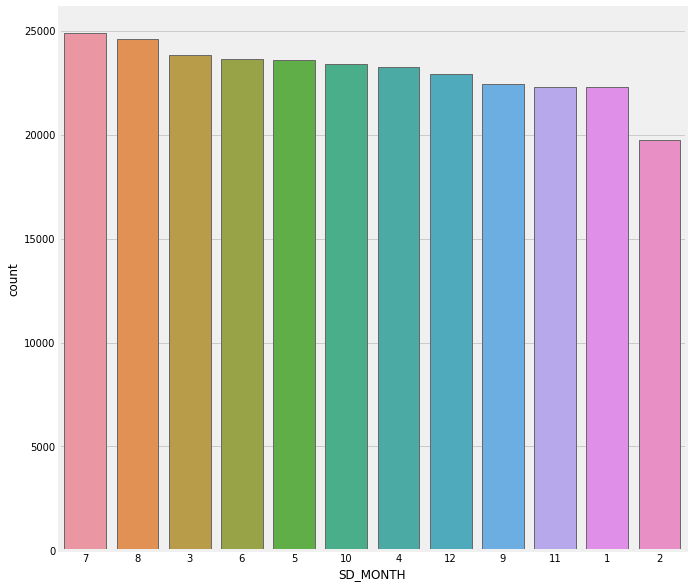

In [69]:
plt.figure(figsize=(10,10))
sns.countplot(
    x='SD_MONTH',
    data=df,
    order = df['SD_MONTH'].value_counts().index
)

### Spring = March 1 to May 31
### Summer = June 1 to August 31 
### Fall (autumn) = September 1 to November 30  
### Winter = December 1 to February 28 (February 29 in a leap year)

# TOTAL_DELAY_MIN dan maskapai untuk setiap bulannya

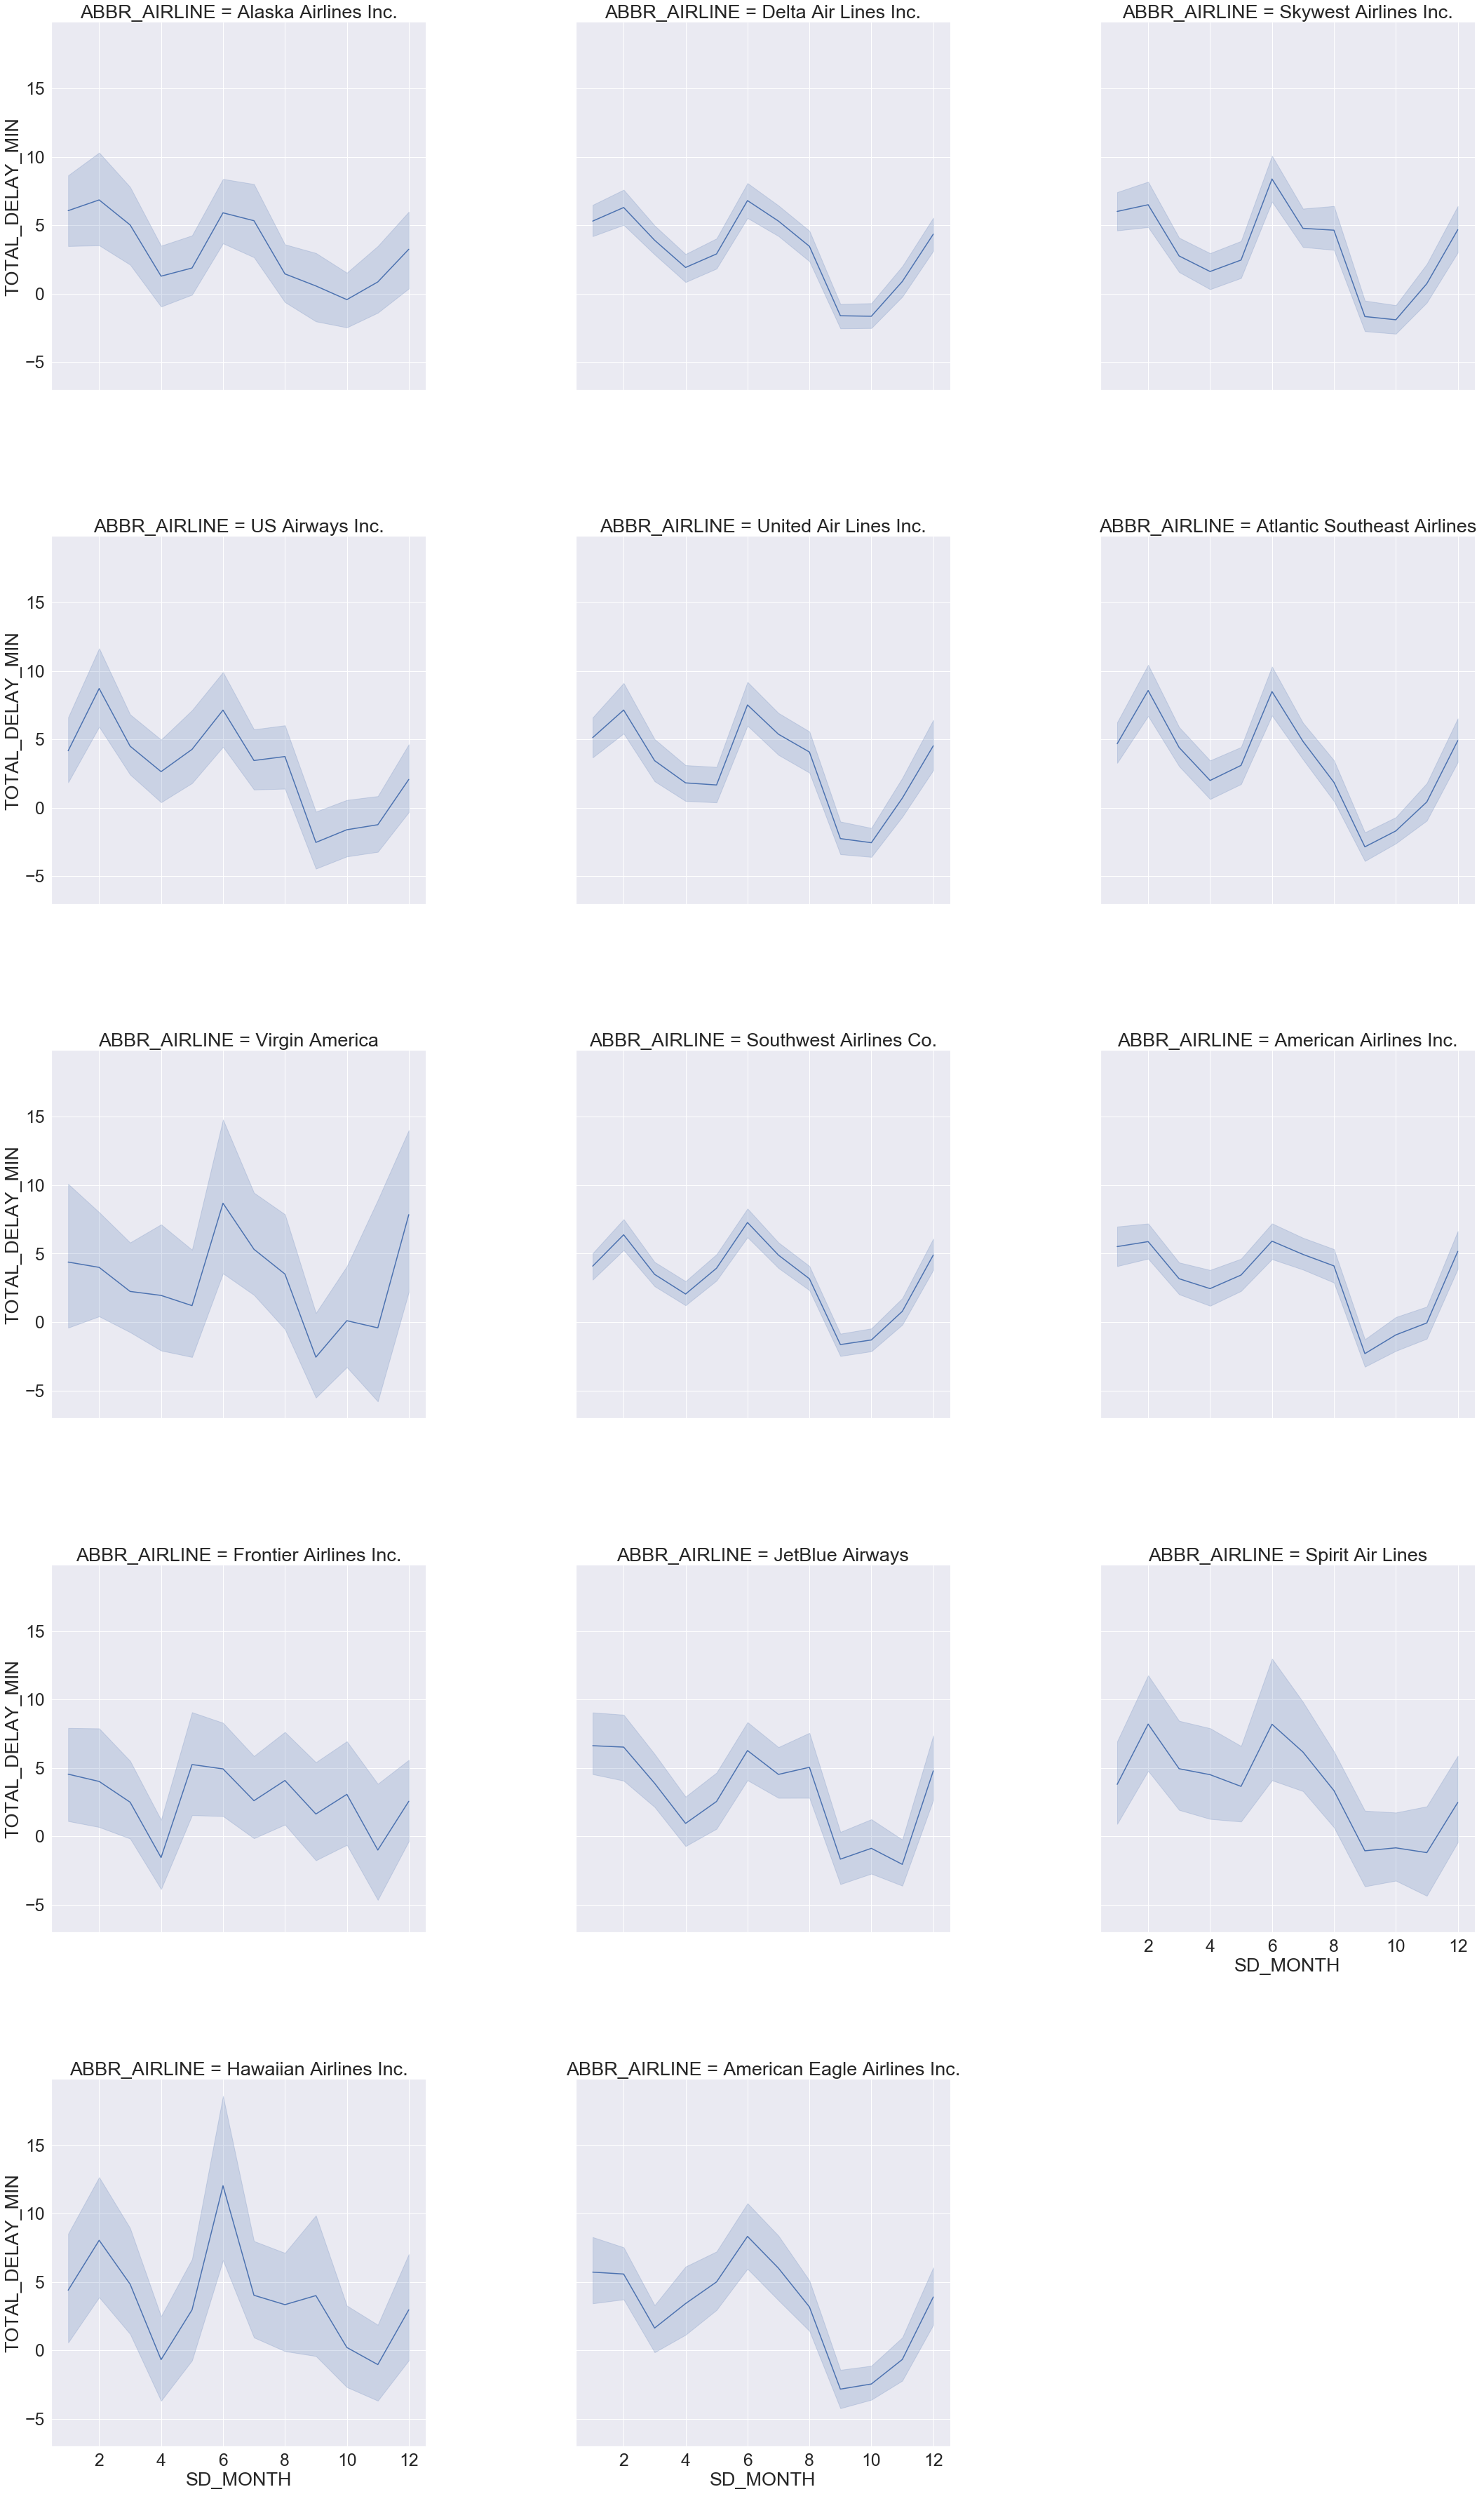

In [70]:
sns.set(font_scale=2.25)
g = sns.FacetGrid(df, col='ABBR_AIRLINE',col_wrap=3,height=10)
g = g.map(sns.lineplot,'SD_MONTH',"TOTAL_DELAY_MIN")
g.fig.subplots_adjust(wspace=0.4, hspace=0.4)

## Dari grafik tersebut kita dapat melihat bahwa delay memuncak pada bulan Februari, Juni, dan Desember.
## Bulan -bulan tersebut merupakan bulan pergi berlibur dimana pada jadwal kalender adalah pergantian musim ataupun libur panjang.
## Hal tsb dibuktikan dengan grafik per maskapai yang menunjukkan pola yang mirip

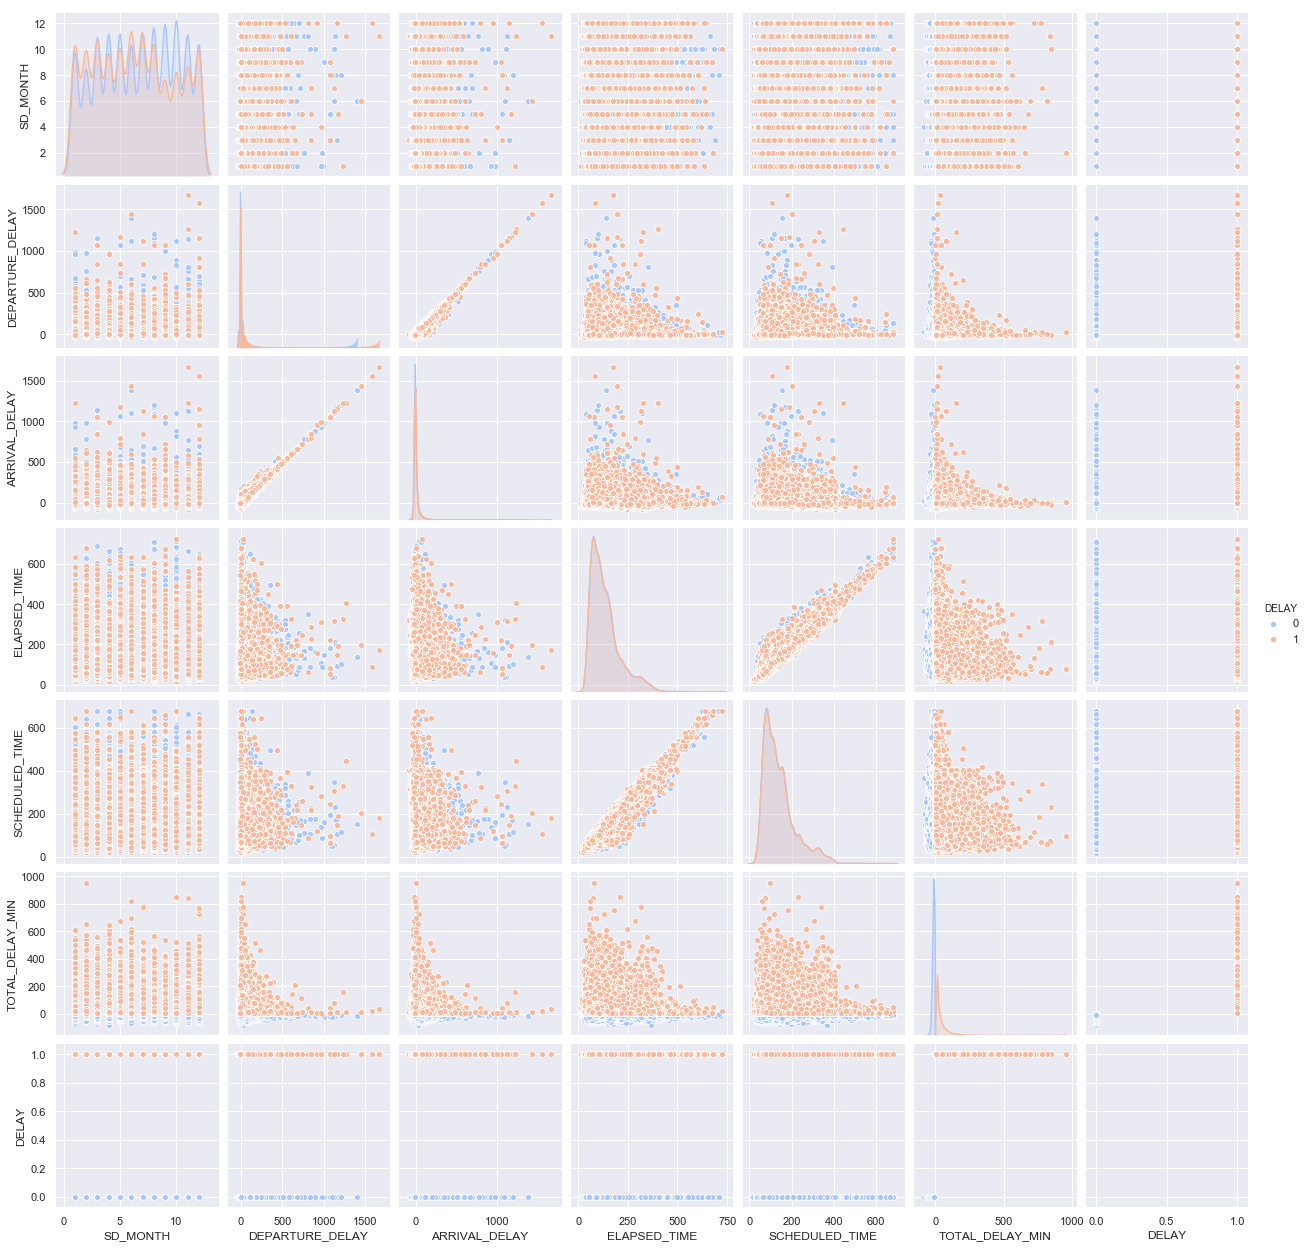

In [71]:
sns.set()
g = sns.pairplot(df[['SD_MONTH','DEPARTURE_DELAY','ARRIVAL_DELAY','ELAPSED_TIME',
         'SCHEDULED_TIME','TOTAL_DELAY_MIN','DELAY']],hue='DELAY',palette = 'coolwarm')
g.fig.subplots_adjust(wspace=0.05, hspace=0.05)

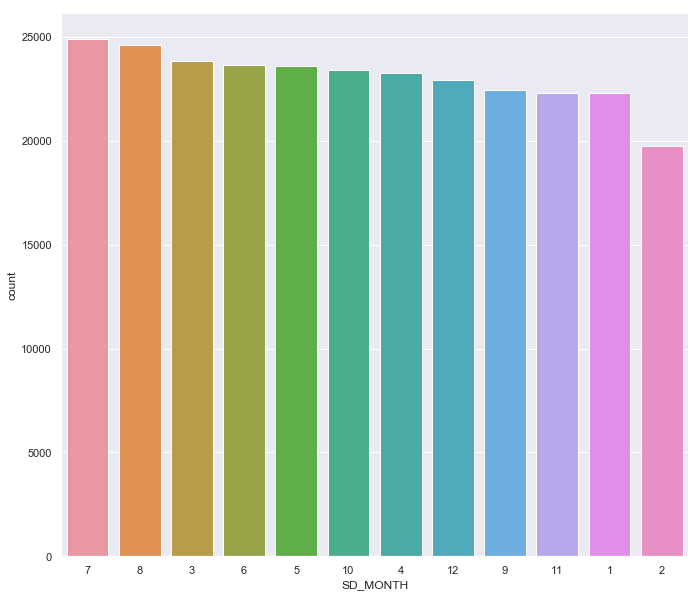

In [72]:
plt.figure(figsize=(10,10))
sns.countplot(
    x='SD_MONTH',
    data=df,
    order = df['SD_MONTH'].value_counts().index
)

# Memperlihatkan jumlah penerbangan yang delay setiap bulannya.

Text(0.5,1,'Number of Delay Flights per Month')

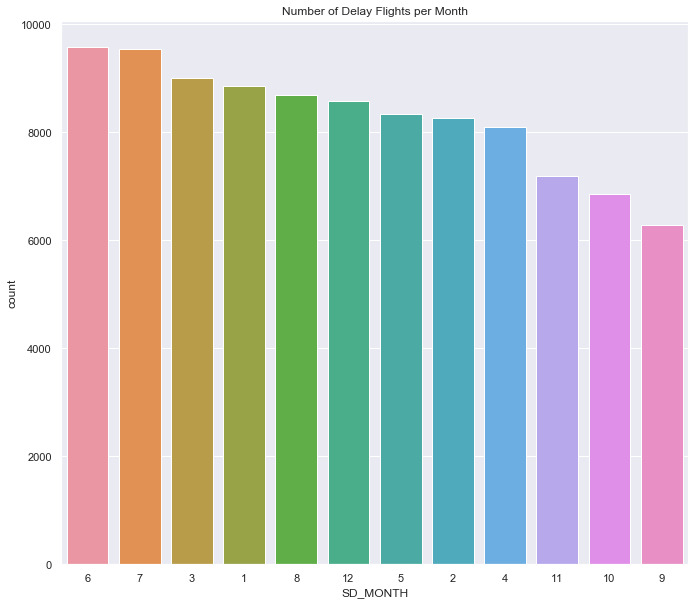

In [73]:
plt.figure(figsize=(10,10))
g = sns.countplot(x='SD_MONTH',data=df[df['DELAY']==1],
              order = df[df['DELAY']==1]['SD_MONTH'].value_counts().index)
g.set_title("Number of Delay Flights per Month")

In [74]:
delay_count = df['SD_MONTH'].value_counts().sort_index()
delay_1 = df[df['DELAY'] == 1]['SD_MONTH'].value_counts().sort_index()

delay_pct = delay_1/delay_count
delay_pct = delay_pct.sort_values(ascending=False)
delay_pct

2     0.418020
6     0.404953
1     0.397621
7     0.382951
3     0.378207
12    0.374329
5     0.353712
8     0.353166
4     0.348219
11    0.322387
10    0.292576
9     0.280337
Name: SD_MONTH, dtype: float64

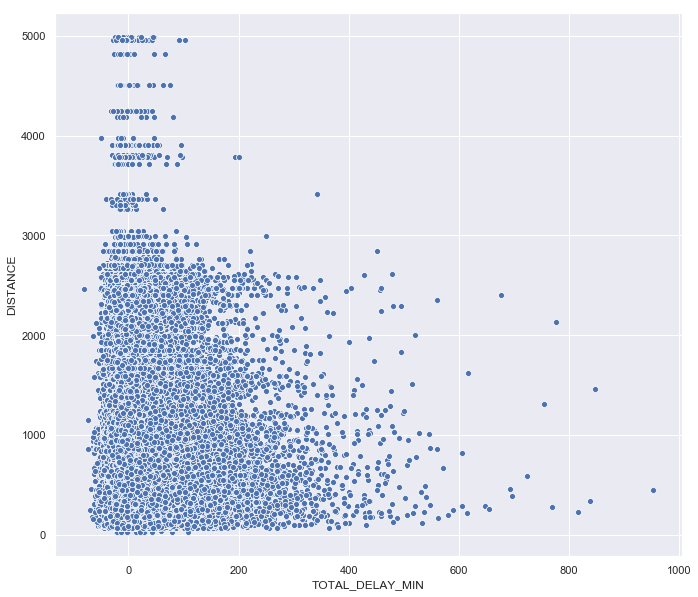

In [75]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(x='TOTAL_DELAY_MIN',y='DISTANCE',data=df)

## Grafik menunjukkan tidak begitu berkorelasi antara jarak dan total delay. Kemungkinan delay lebih justru ditunjukkan apabila jarak destinasi lebih dekat.

# Grafik menunjukkan bagaimana delay berkorelasi dengan feature lain

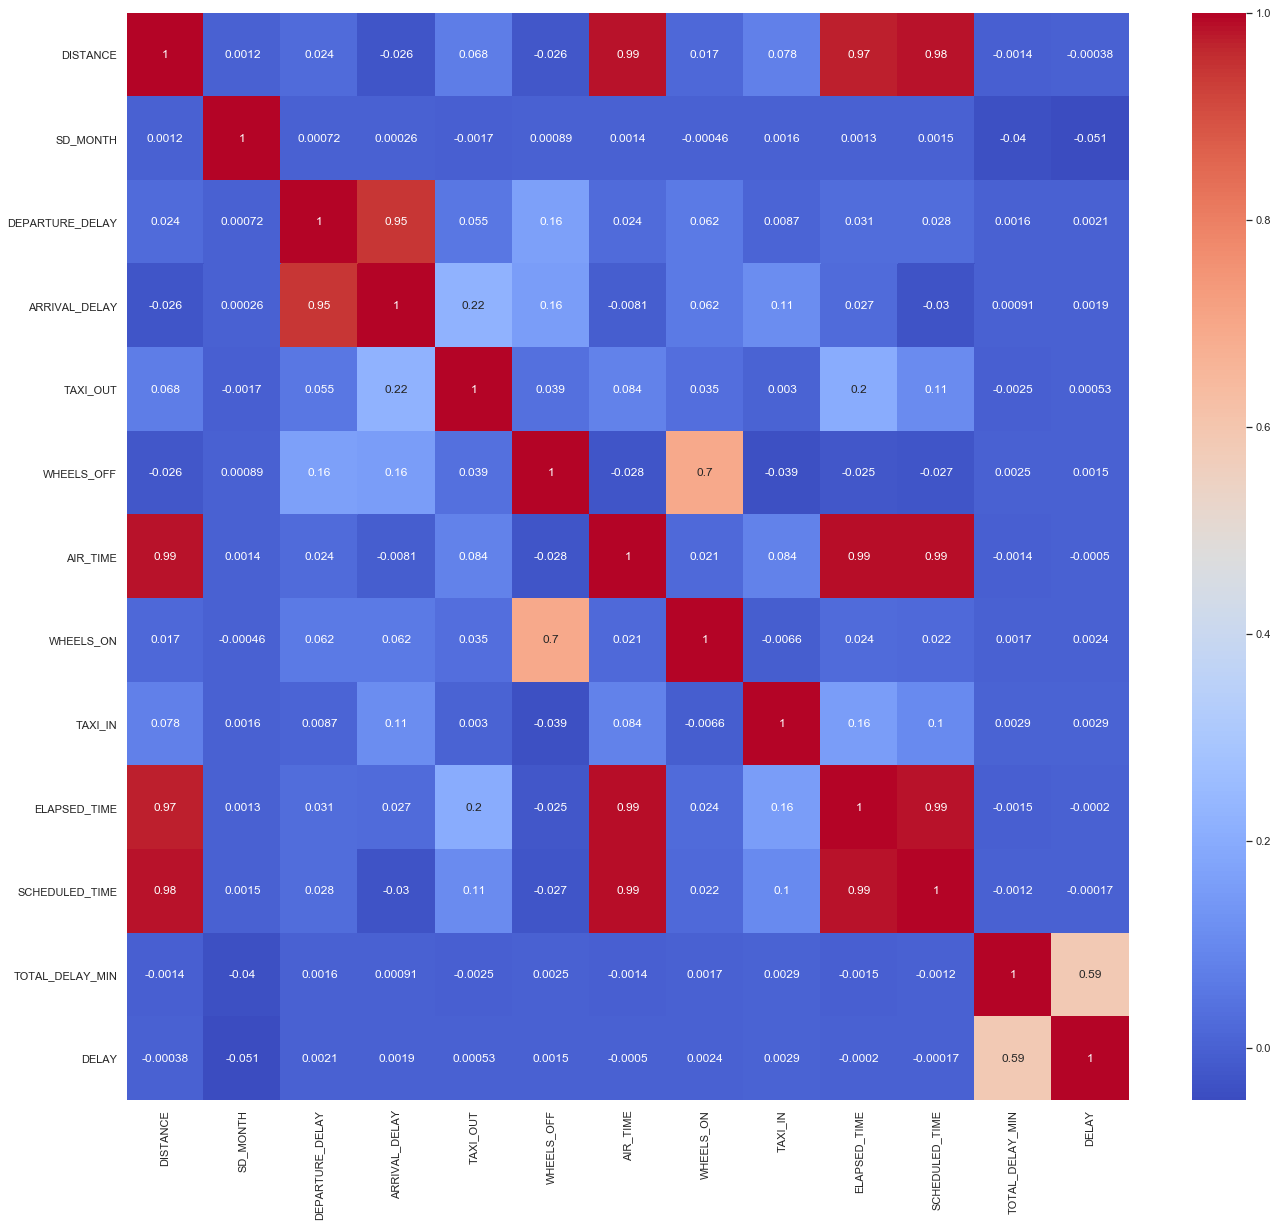

In [76]:
plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

### Dari grafik diatas dapat kita lihat yang paling berkorelasi positif dan korelasi negatif terkuat, untuk nantinya dapat membantu kita dalam prediksi

### Bandara yang paling sering mengalami delay

In [77]:
gb_origin = df.groupby('ORIGIN_AIRPORT')
origin_delay = gb_origin.DELAY.count().sort_values(ascending=False)
print(origin_delay.head())
gb_dest = df.groupby('DESTINATION_AIRPORT')
dest_delay = gb_dest.DELAY.count().sort_values(ascending=False)
print(dest_delay.head())

ORIGIN_AIRPORT
ATL    16952
ORD    13475
DFW    11307
LAX     9455
DEN     9334
Name: DELAY, dtype: int64
DESTINATION_AIRPORT
ATL    16630
ORD    13362
DFW    11248
DEN     9348
LAX     9190
Name: DELAY, dtype: int64


In [78]:
# gb_origin = df.groupby('ORIGIN_AIRPORT')

condition = ((-30<df['TOTAL_DELAY_MIN'])&(df['TOTAL_DELAY_MIN']<=60))
df.groupby('ORIGIN_AIRPORT').describe()['DELAY']>100
origin_delay = gb_origin.DELAY.count()
origin_delay.count()

# gb_count = gb_origin["DELAY"].count()
# gb_final = gb_origin["DELAY"].describe()
# gb_final[gb_final['count']>100][['mean', 'count']].sort_values(by = ['count', 'mean'], ascending=False)

620

# Banyak kesimpulan yang dapat diambil dari Eksplorasi Data Analisis, seperti :

### Bagaimana performa setiap maskapai.
### Presentase kemungkinan delay setiap maskapainya.
### Bulan bulan apa saja, terjadinya delay paling banyak.
### Bandara yang paling sering mengalami delay.

# Dari hasil EDA kita dapat mengambil kebijakan –kebijakan untuk untuk meningkatkan kinerja maskapai maupun bandara:
## Mempersiapkan armada penerbangan untuk menghadapi bulan -bulan dimana delay paling riskan terjadi.
## Mengurangi risiko delay pada bandara -bandara yang mengalami delay terbanyak untuk meningkatkan pelayanan dan performa bandara maupun maskapai.
## Meningkatkan kinerja maskapai dengan melihat presentase delay maskapai untuk menghindari kerugian. 

Text(0.5,0,'Number of Delays occur')

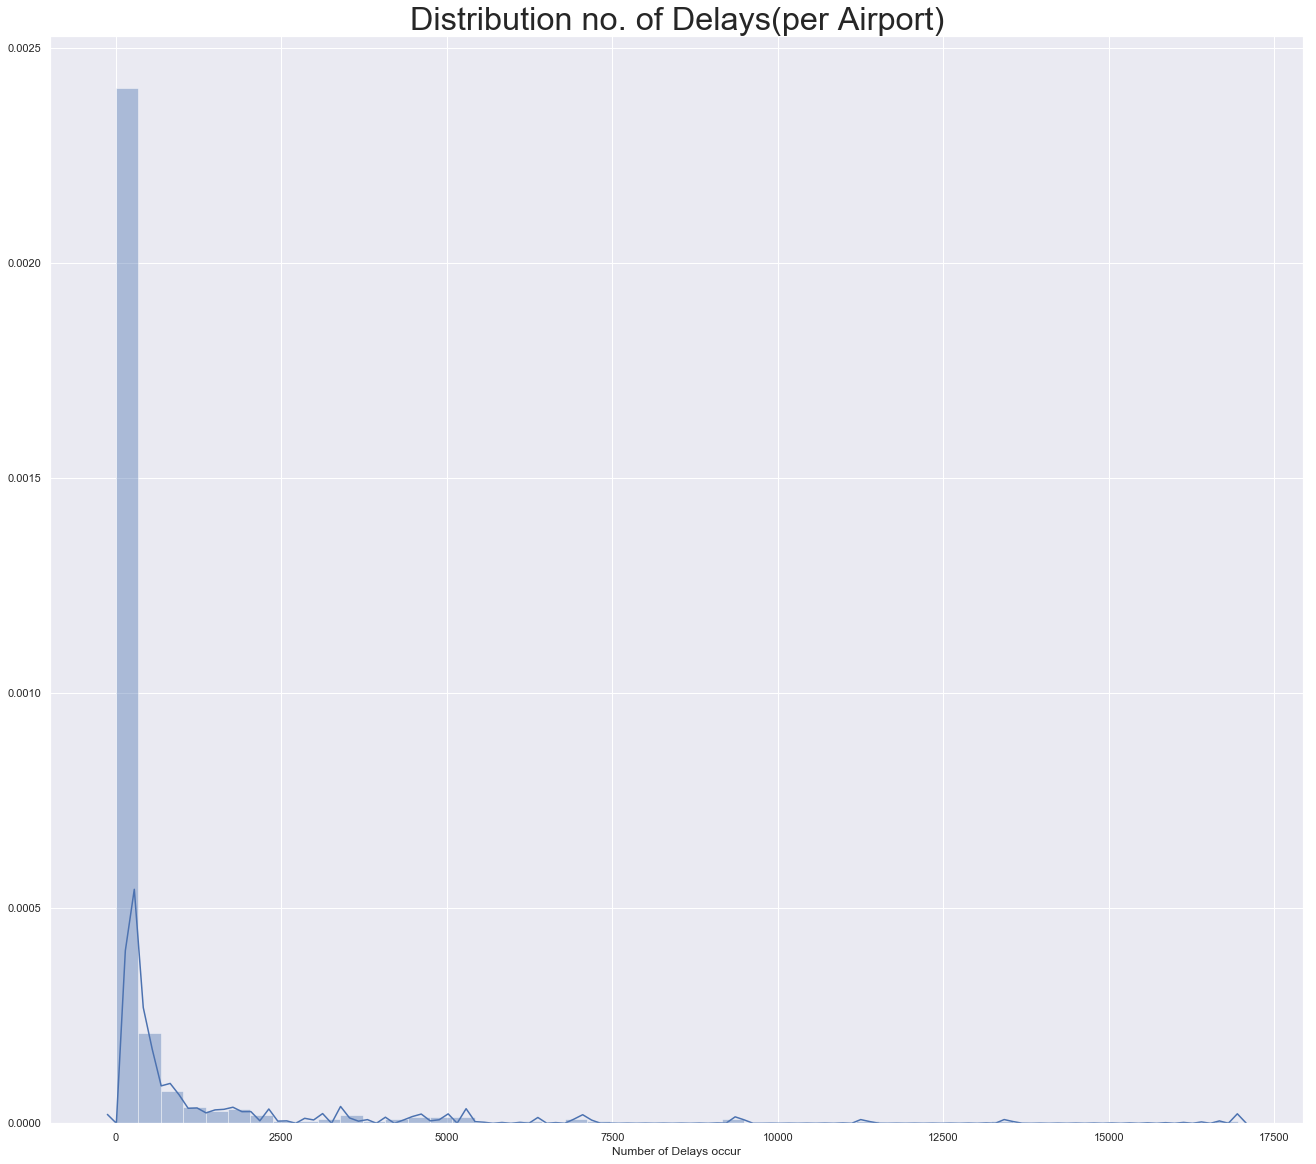

In [79]:
plt.subplots(figsize=(20,20))
sns.set(font_scale=2.7)
g = sns.distplot(origin_delay)
g.set_title("Distribution no. of Delays(per Airport)")
g.set_xlabel('Number of Delays occur')

### Tren Distribusi dari 0-1000 jumlah delay per bandara, akan tetapi beberapa bandara yang memiliki lebih dari 3000 delay.
## Yang mengartikan pada bandara yang (>3000) memiliki lebih besar kemungkinan terjadi delay. 
### Sedangkan untuk bandara bandara yang lain, tidak dapat ditarik kesimpulan yang sama.

In [80]:
condition = ((-30<df['TOTAL_DELAY_MIN'])&(df['TOTAL_DELAY_MIN']<=60))&(df['DEPARTURE_DELAY']<=50)&(df['ARRIVAL_DELAY']<=50)
df = df[condition]
df.min()

AIRLINE                                  AA
ABBR_AIRLINE           Alaska Airlines Inc.
ORIGIN_AIRPORT                        10135
DESTINATION_AIRPORT                   10135
DISTANCE                                 31
SD_MONTH                                  1
SCHEDULED_DEPARTURE     2015-01-01 00:05:00
DEPARTURE_TIME          2015-01-01 00:33:00
DEPARTURE_DELAY                         -36
SCHEDULED_ARRIVAL       2015-01-01 00:06:00
ARRIVAL_TIME            2015-01-01 00:16:00
ARRIVAL_DELAY                           -81
TAXI_OUT                                  1
WHEELS_OFF                                1
AIR_TIME                                  7
WHEELS_ON                                 1
TAXI_IN                                   1
ELAPSED_TIME                             17
SCHEDULED_TIME                           18
TOTAL_DELAY               -1 days +23:31:00
TOTAL_DELAY_MIN                         -29
DELAY                                     0
dtype: object

In [81]:
df.to_csv('sample_Flights_Delay.csv',index=False)